# Classifying Readmissions using Diabetes Data (Diabetes 130-US Hospitals)

Sebu Eisaian - 55033063

Jimmy Jin - 90792801

Jay Phil Yoo - 62053128

In [1]:
import numpy as np

import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.impute import SimpleImputer
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

IMPORT THE FILE

In [2]:
X = pd.read_csv('Data/diabetic_data.csv')

FIGURE OUT THE NON NUMERIC COLUMNS  

In [3]:
non_numeric_columns = X.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)
print(len(non_numeric_columns))

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
37


TRANSFER READMITTED COLUMN VALUES TO Y AND REMOVE COLUMNS WITH MORE THAN 80% MISSING VALUES

In [4]:
y = X['readmitted']


# get drop list with columns consisted with 80% or more of same values. Mostly null values.
drop_list = []
for col in X.columns:
    X[col].replace('?', None, inplace = True)
    X[col].replace('No', 0, inplace = True)
    X[col].replace('None', 0, inplace = True)
    
    val_counts = X[col].value_counts()
    if val_counts.iloc[0] / val_counts.sum() > 0.8:
        drop_list.append(col)

for elem in drop_list:
    X.drop([elem], axis = 1, inplace = True)
    
#23!

In [5]:
# HERE WE CONVERT ALL NON NUMERIC COLUMNS TO NUMERIC
#y.replace('>30', 2, inplace = True)
#y.replace('<30', 1, inplace = True)
#y.replace('NO', 0, inplace = True)

#prepare age column by converting object to int values
for val in list(set(X['age'].values)):
    X['age'].replace(val, val[-3:-1], inplace = True)

X['age'].replace('00', 100, inplace = True)

for val in list(set(X['age'].values)):
    X['age'].replace(val, int(val), inplace = True)

#prepare insulin column converting objects to int
#X['insulin'].replace('Down', -1, inplace = True)
#X['insulin'].replace('No', 0, inplace = True)
#X['insulin'].replace('Steady', 1, inplace = True)
#X['insulin'].replace('Up', 2, inplace = True)

#prepare change column converting objects to int
#X['change'].replace('Ch', 1, inplace = True)
#X['change'].replace('No', 0, inplace = True)

#prepare diabetesMed column
X['diabetesMed'].replace('No', 0, inplace = True)
X['diabetesMed'].replace('Yes', 1, inplace = True)

for val in list(set(X['diag_1'].values)):
    if val != None and val[0].isalpha():
        X['diag_1'].replace(val, None, inplace = True)
    elif val ==None:
        pass
    else:
        X['diag_1'].replace(val, float(val), inplace = True)

for val in list(set(X['diag_2'].values)):
    if val != None and val[0].isalpha():
        X['diag_2'].replace(val, None, inplace = True)
    elif val ==None:
        pass
    else:
        X['diag_2'].replace(val, float(val), inplace = True)

for val in list(set(X['diag_3'].values)):
    if val != None and val[0].isalpha():
        X['diag_3'].replace(val, None, inplace = True)
    elif val ==None:
        pass
    else:
        X['diag_3'].replace(val, float(val), inplace = True)

In [6]:
le = LabelEncoder()
for col in X.columns:
    if X.dtypes[col] == object:
        X[col] = le.fit_transform(X[col])

In [7]:
X.fillna(X.mean(), inplace=True)

In [8]:
X.shape

(101766, 26)

In [9]:
X.dtypes

encounter_id                  int64
patient_nbr                   int64
race                          int32
gender                        int32
age                           int64
weight                        int32
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
payer_code                    int32
medical_specialty             int32
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_inpatient              int64
diag_1                      float64
diag_2                      float64
diag_3                      float64
number_diagnoses              int64
max_glu_serum                 int32
A1Cresult                     int32
insulin                       int64
change                        int64
diabetesMed                   int64
readmitted                    int64
dtype: object

In [10]:
#REMOVE UNNECESSARY COLUMNS
X.drop(['encounter_id','patient_nbr','payer_code'], axis = 1, inplace = True)

In [11]:
X

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,diabetesMed,readmitted
0,2,0,10,9,6,25,1,1,37,41,...,250.83,438.674883,418.179285,1,3,3,0,0,0,0
1,2,0,20,9,1,1,7,3,72,59,...,276.00,250.010000,255.000000,9,3,3,2,1,1,2
2,0,0,30,9,1,1,7,2,72,11,...,648.00,250.000000,418.179285,6,3,3,0,0,1,0
3,2,1,40,9,1,1,7,2,72,44,...,8.00,250.430000,403.000000,7,3,3,2,1,1,0
4,2,1,50,9,1,1,7,1,72,51,...,197.00,157.000000,250.000000,5,3,3,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,0,1,80,9,1,3,7,3,72,51,...,250.13,291.000000,458.000000,9,3,1,-1,1,1,2
101762,0,0,90,9,1,4,5,5,72,33,...,560.00,276.000000,787.000000,9,3,3,1,0,1,0
101763,2,1,80,9,1,1,7,1,72,53,...,38.00,590.000000,296.000000,13,3,3,-1,1,1,0
101764,2,0,90,9,2,3,7,10,62,45,...,996.00,285.000000,998.000000,9,3,3,2,1,1,0


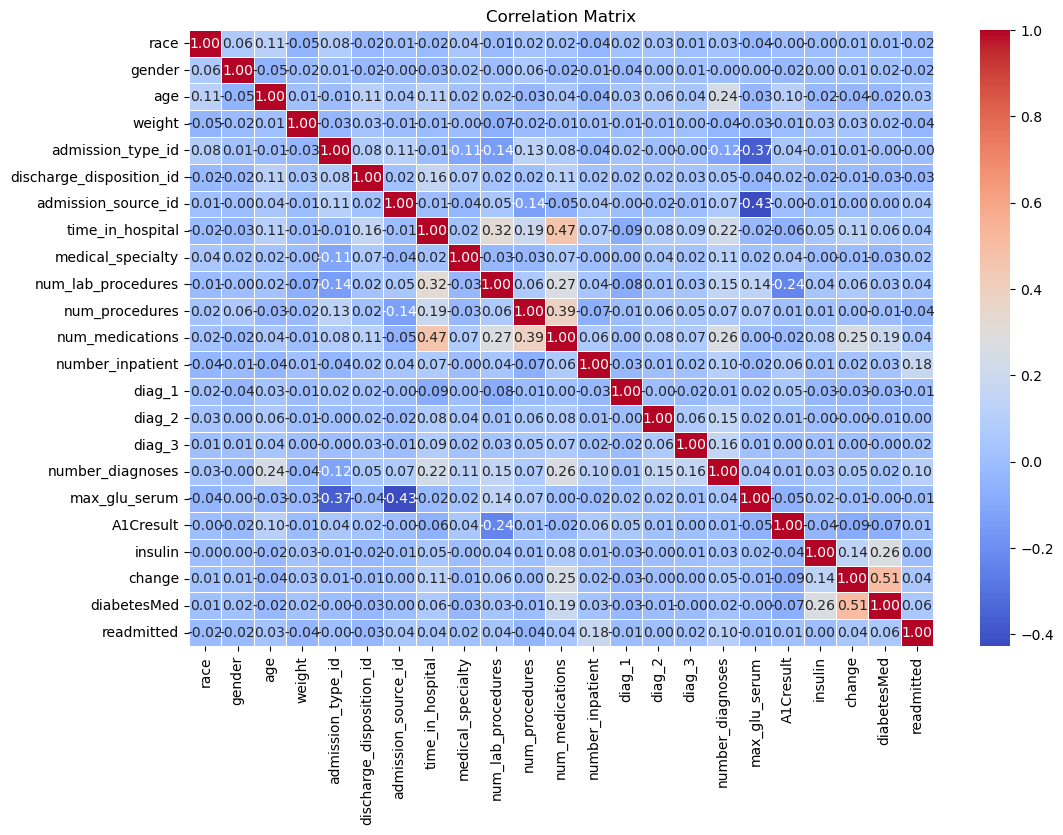


Correlation with 'readmitted':
readmitted                  1.000000
number_inpatient            0.178208
number_diagnoses            0.104660
diabetesMed                 0.057168
change                      0.043028
admission_source_id         0.041193
time_in_hospital            0.040309
num_medications             0.037399
num_lab_procedures          0.035441
age                         0.026816
diag_3                      0.017870
medical_specialty           0.017210
A1Cresult                   0.010474
diag_2                      0.004086
insulin                     0.001945
admission_type_id          -0.001342
diag_1                     -0.010216
max_glu_serum              -0.011602
gender                     -0.018529
race                       -0.019885
discharge_disposition_id   -0.033281
weight                     -0.036425
num_procedures             -0.044150
Name: readmitted, dtype: float64


In [12]:
#CORRELATION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt
# Select the relevant features based on positive correlation

# Combine X and y into one dataframe to calculate correlation
X_with_y = X.copy()  # Make a copy of X to include the target
X_with_y['readmitted'] = y  # Add the target column to X

# Compute the correlation matrix
corr_matrix = X_with_y.corr()

# Plot the correlation matrix for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Check correlation of each feature with the target column 'readmitted'
print("\nCorrelation with 'readmitted':")
print(corr_matrix['readmitted'].sort_values(ascending=False))


## Visualization

In [13]:
X

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,diabetesMed,readmitted
0,2,0,10,9,6,25,1,1,37,41,...,250.83,438.674883,418.179285,1,3,3,0,0,0,0
1,2,0,20,9,1,1,7,3,72,59,...,276.00,250.010000,255.000000,9,3,3,2,1,1,2
2,0,0,30,9,1,1,7,2,72,11,...,648.00,250.000000,418.179285,6,3,3,0,0,1,0
3,2,1,40,9,1,1,7,2,72,44,...,8.00,250.430000,403.000000,7,3,3,2,1,1,0
4,2,1,50,9,1,1,7,1,72,51,...,197.00,157.000000,250.000000,5,3,3,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,0,1,80,9,1,3,7,3,72,51,...,250.13,291.000000,458.000000,9,3,1,-1,1,1,2
101762,0,0,90,9,1,4,5,5,72,33,...,560.00,276.000000,787.000000,9,3,3,1,0,1,0
101763,2,1,80,9,1,1,7,1,72,53,...,38.00,590.000000,296.000000,13,3,3,-1,1,1,0
101764,2,0,90,9,2,3,7,10,62,45,...,996.00,285.000000,998.000000,9,3,3,2,1,1,0


In [14]:
X.dtypes

race                          int32
gender                        int32
age                           int64
weight                        int32
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
medical_specialty             int32
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_inpatient              int64
diag_1                      float64
diag_2                      float64
diag_3                      float64
number_diagnoses              int64
max_glu_serum                 int32
A1Cresult                     int32
insulin                       int64
change                        int64
diabetesMed                   int64
readmitted                    int64
dtype: object

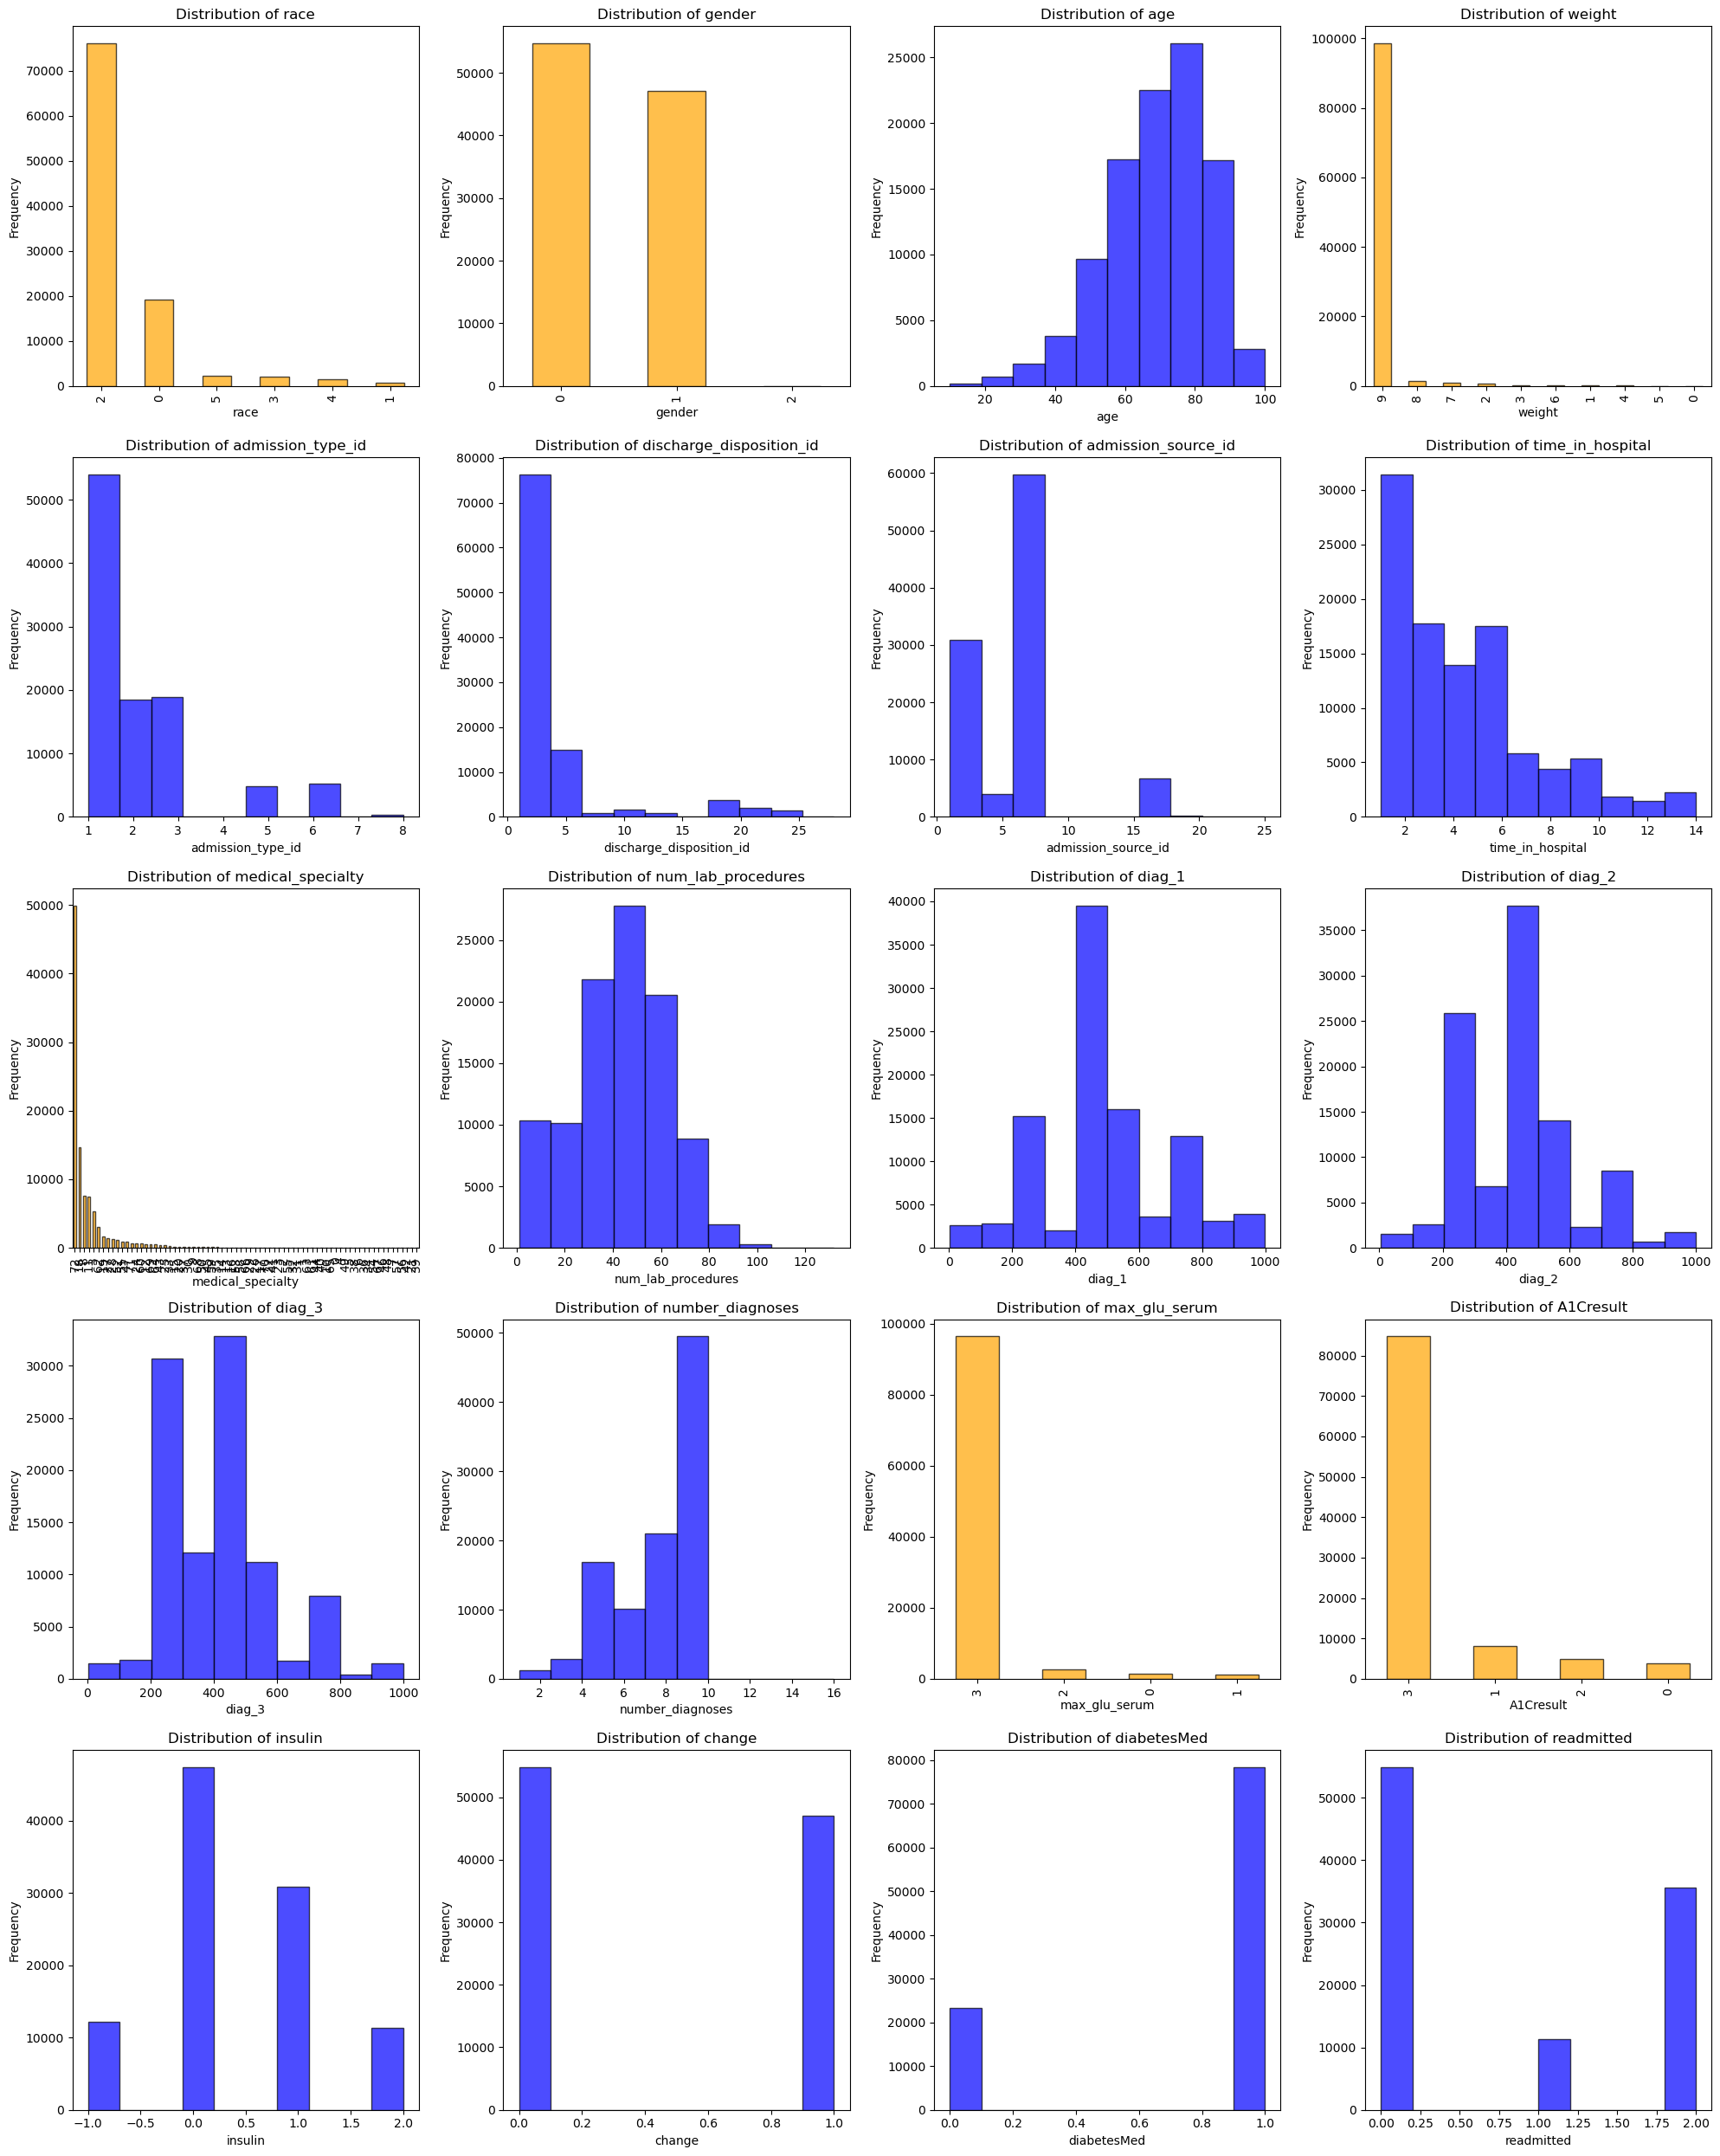

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Columns to plot
columns_to_plot = [
    'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
    'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
    'insulin', 'change', 'diabetesMed', 'readmitted'
]

# Determine grid size
num_cols = 4
num_rows = int(np.ceil(len(columns_to_plot) / num_cols))

# Set up the grid layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Plot each column
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    if X[col].dtype in ['int64', 'float64']:
        # Histogram for numerical data
        ax.hist(X[col], bins=10, color='blue', alpha=0.7, edgecolor='black')
    else:
        # Bar chart for categorical data
        X[col].value_counts().plot(kind='bar', ax=ax, color='orange', alpha=0.7, edgecolor='black')
    
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()
